# Linear Methods

In [118]:
import numpy as np
import pandas as pd
import cvxpy as cp
import quantstats as qs
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from qs import calc_factor, calc_return

## Prepare Data

In [14]:
crsp = pd.read_parquet("./data/crsp.parquet")
glb = pd.read_parquet("./data/glb.parquet")
mfis = pd.read_parquet("./data/mfis.parquet")
famafrench = pd.read_parquet("./data/famafrench.parquet") 
optionmetrics = pd.read_parquet("./data/optionmetrics.parquet")

In [310]:
factor = calc_factor(crsp, famafrench, mfis, glb, "W-FRI")
ret = calc_return(crsp, famafrench, "W-FRI")

/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Tuning

In [235]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits


In [311]:
def get_train_valid(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    return X_train, y_train, X_val, y_val

In [312]:
def cross_validation(reg):
    r2_ = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
        X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        r2_.append(r2)
        print(f"fold: {fold}, r2: {r2}")
    print(f"Avg. r2: {np.mean(r2_)}")

In [316]:
cv = MultipleTimeSeriesCV(n_splits=6,
                          train_period_length=6*52,
                          test_period_length=52)

X = factor["2000-01-01":"2012-12-31"] 
y = ret.shift(-1).loc["2000-01-01":"2012-12-31"]
reg = LinearRegression()
cross_validation(reg)

fold: 0, r2: 0.009366217944611455
fold: 1, r2: 0.032036282077284706
fold: 2, r2: 0.010936152470957361
fold: 3, r2: 0.016508315032989218
fold: 4, r2: 0.010042236900454915
fold: 5, r2: 0.008814653267730232
Avg. r2: 0.014617309615671314


In [317]:
reg = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
cross_validation(reg)

fold: 0, r2: 0.00931055295737504
fold: 1, r2: 0.031890994961637165
fold: 2, r2: 0.01096970405777864
fold: 3, r2: 0.01649821612925706
fold: 4, r2: 0.012062477381353798
fold: 5, r2: 0.008602484794597132
Avg. r2: 0.014889071713666472


In [318]:
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.0005))
cross_validation(reg)

fold: 0, r2: 0.010858334332276565
fold: 1, r2: 0.031132985777281186
fold: 2, r2: 0.009912453049848446
fold: 3, r2: 0.015725748234248882
fold: 4, r2: 0.01335973785767497
fold: 5, r2: 0.013820574780697759
Avg. r2: 0.01580163900533797


## Backtest

In [319]:
X = factor["2000-01-01":"2019-11-30"] 
y = ret.shift(-1).loc["2000-01-01":"2019-11-30"]
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.0005))

In [320]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
    reg.fit(X_train, y_train)
    predictions.append(pd.Series(reg.predict(X_val).reshape(-1), index=y_val.index))
y_pred = pd.concat(predictions).sort_index()
y_val = y[y_pred.index]
r2_score(y_val, y_pred)

0.002460880026639911

In [321]:
def calc_w():
    w_optimal = pd.Series(None, index=y_pred.index, dtype="float")
    w_caps = crsp[["date", "permno", "w_cap"]].groupby([pd.Grouper(key="date", freq="W-FRI"), "permno"]).w_cap.last()
    unique_dates = y_pred.index.get_level_values("date").unique()
    for date in tqdm(unique_dates):
        w_cap = w_caps[date].to_numpy()
        mu = y_pred[date].to_numpy()
        Sigma = crsp[crsp.date <= date].pivot(index="date", columns="permno", values="ret").tail(252).cov().to_numpy()
        # Beta = X[X.index.get_level_values("date") == date].drop(columns="ret")
        # The shape of the variables should be as follows
        assert Sigma.shape == (50, 50)
        # assert Beta.shape == (50, 14)
        assert mu.shape == (50,)
        assert w_cap.shape == (50,)
        # w is the weights for 50 stocks
        w = cp.Variable(50)
        # ret is expected return times weights (Does the return need to be adjusted with risk free rate?)
        ret = mu.T@w 
        # risk is cov matrix with weights in quadratic form, w.T@Sigma@w
        risk = cp.quad_form(w, Sigma)
        # gamma is the risk aversion parameter
        gamma = cp.Parameter(nonneg=True)
        # Say gamma is 0, we maximize return, this can be adjusted
        gamma.value = 0.5
        # Classical Markowitz portfolio optimization (Does risk need to be sqrt or not?)
        obj = cp.Maximize(ret - gamma*risk)
        # Constraints
        constraints = [w >= 0, # Long-only
                    cp.sum(w) == 1, # Sum of weights equal to 1
                    #Beta.T @ ((w - w_cap) / w_cap) <= 0.05, # Factor exposure deviation <= 0.05
                    #Beta.T @ ((w - w_cap) / w_cap) >= -0.05, # Factor exposure deviation >= -0.05
                    (w - w_cap) / w_cap <= 0.1, # Weight deviation <= 0.1
                    (w - w_cap) / w_cap >= -0.1, # Weight deviation >= -0.1
                    #(1 + mu.T) @ ((w - w_cap) / w_cap) >= -0.01, # Drawdown relative to benchmark >= -0.01
                    ]
        prob = cp.Problem(obj, constraints)
        prob.solve(solver="ECOS")
        w_optimal[date] = np.asarray(w.value).flatten()
    return w_optimal

In [326]:
bt = crsp.set_index(["date", "permno"]).loc["2013-01-01":"2019-12-31", ["ret", "w_cap"]]
bt["w_optimal"] = calc_w()
bt["w_optimal"] = bt.groupby("permno").w_optimal.fillna(method="ffill")
# bt["w_optimal"] = bt.groupby("permno").w_optimal.shift(1)
bt = bt.dropna()

100%|██████████| 312/312 [00:16<00:00, 18.81it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-12-13  2013-12-13
End Period                 2019-12-31  2019-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          107.06%     102.77%
CAGR﹪                     12.78%      12.39%

Sharpe                     1.16        1.13
Smart Sharpe               1.13        1.1
Sortino                    1.65        1.6
Smart Sortino              1.61        1.56
Sortino/√2                 1.17        1.13
Smart Sortino/√2           1.14        1.1
Omega                      1.22        1.22

Max Drawdown               -12.88%     -13.02%
Longest DD Days            406         412
Volatility (ann.)          10.9%       10.92%
R^2                        1.0         1.0
Calmar                     0.99        0.95
Skew                       -0.46       -0.45
Kurtosis                   3.18        3.1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-23,2015-08-25,2016-03-04,406,-12.878504,-11.537439
2,2018-12-03,2018-12-24,2019-02-22,81,-11.017798,-8.868715
3,2018-01-29,2018-05-02,2018-09-12,226,-10.063892,-9.952737
4,2016-07-25,2016-12-01,2017-02-03,193,-6.029889,-5.399175
5,2018-09-24,2018-10-11,2018-11-06,43,-5.460591,-4.899243


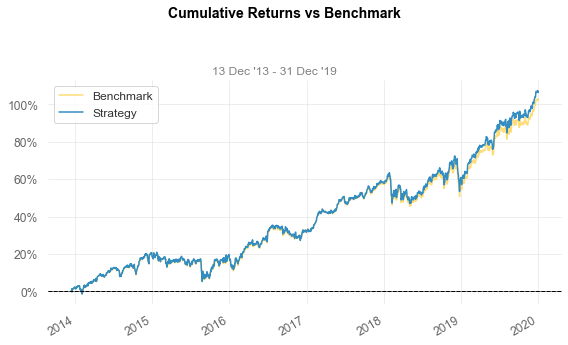

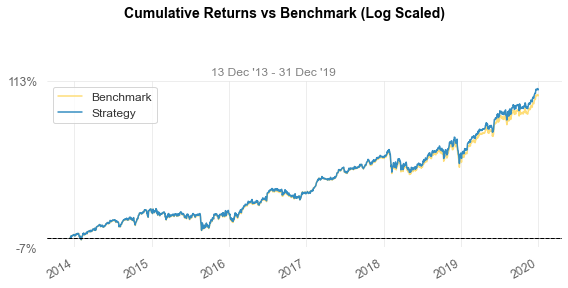

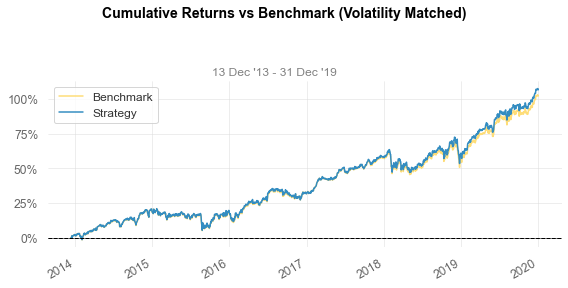

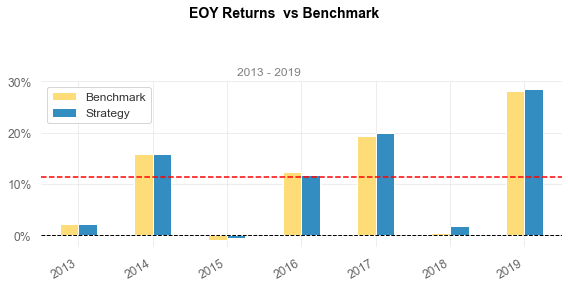

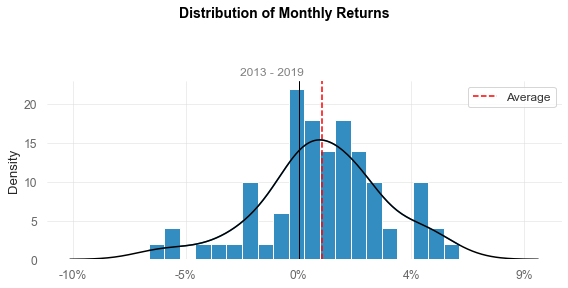

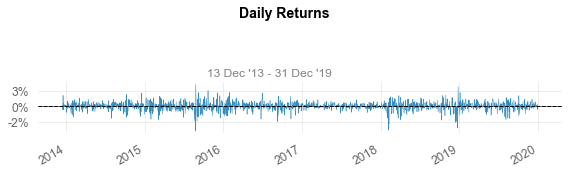

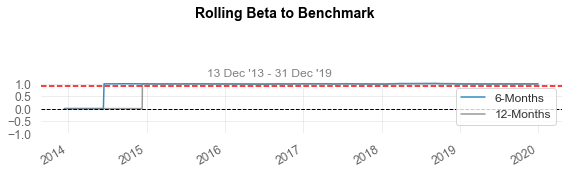

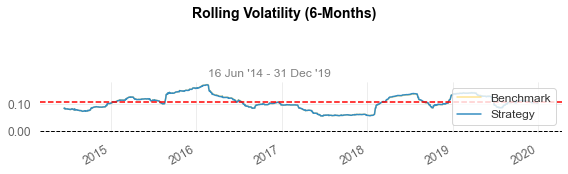

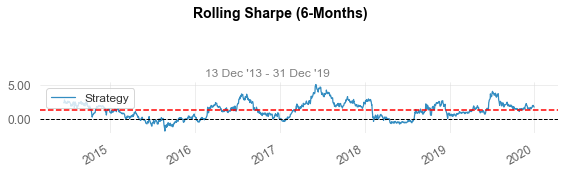

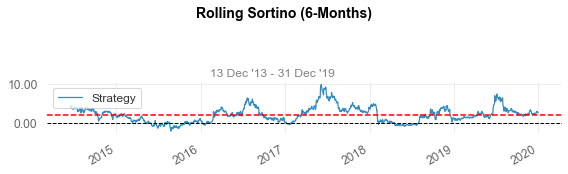

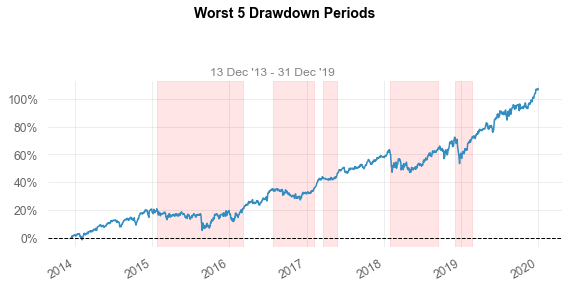

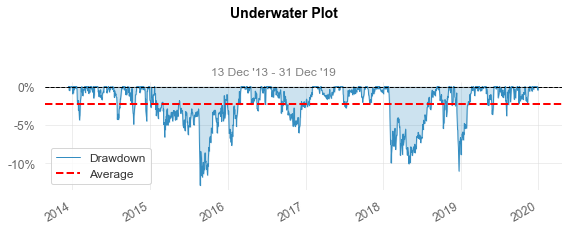

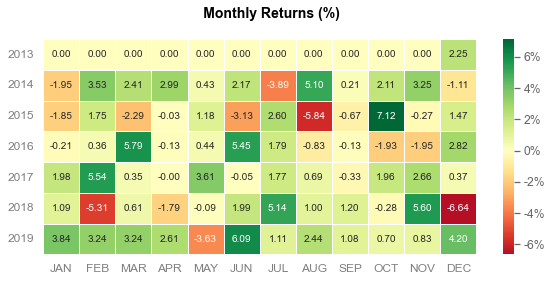

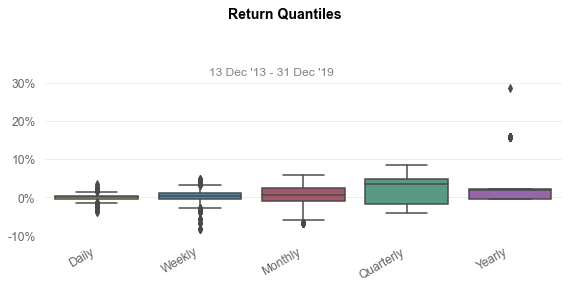

In [327]:
bnch_ret = (bt.ret * bt.w_cap).groupby("date").sum()
bt_ret = (bt.ret * bt.w_optimal).groupby("date").sum()
qs.reports.full(bt_ret, bnch_ret)